# Практическое задание на тему "Классификация комментариев на ревью"

In [16]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from transformers import RobertaTokenizer
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [17]:
# Путь до исходного DataSet
data_path = "ToxiCR/models/code-review-dataset-full.xlsx"
# Файл куда будет сохранен датасет, после предпроцессинга
preprocessed_data_path = "preprocessed_data.csv"
# Сид для рандома
random_state = 27

## Подзадача 1: Подготовка набора данных

In [39]:
df = pd.read_excel(data_path)
df

,message,is_toxic
0,This and below assignments also should be removed,0
1,this should be flavor_id = self.flavor_id,0
2,bool session_adopted_ = false;,0
3,"nit: Starting C++11, this could be done direct...",0
4,I am confused.\n \n This is the tar process we...,0
...,...,...
19646,Amazing!!! I bet that contributed a lot to our...,0
19647,great catch,0
19648,"Wow, this is amazing.",0
19649,This is awesome.,0


### 1. Проведите очистку набора данных, устраняя пропущенные значения и дубликаты.

In [40]:
df = df.dropna()
df = df.drop_duplicates()
df

,message,is_toxic
0,This and below assignments also should be removed,0
1,this should be flavor_id = self.flavor_id,0
2,bool session_adopted_ = false;,0
3,"nit: Starting C++11, this could be done direct...",0
4,I am confused.\n \n This is the tar process we...,0
...,...,...
19646,Amazing!!! I bet that contributed a lot to our...,0
19647,great catch,0
19648,"Wow, this is amazing.",0
19649,This is awesome.,0


Удалив строки с пробелами и дубликатами, мы уменьшили датасет примерно на 7 000 строк

### 2. Подготовьте текстовые данные для анализа

In [41]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not",
                       "can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not",
                       "didn't": "did not", "doesn't": "does not",
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not",
                       "haven't": "have not", "he'd": "he would", "he'll": "he will",
                       "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
                       "how'll": "how will", "how's": "how is", "I'd": "I would",
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will", "i'll've": "i will have", "i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                       "might've": "might have", "mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have",
                       "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not",
                       "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have",
                       "she's": "she is", "should've": "should have", "shouldn't": "should not",
                       "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
                       "this's": "this is", "that'd": "that would", "that'd've": "that would have",
                       "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is",
                       "here's": "here is", "they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will",
                       "what'll've": "what will have", "what're": "what are", "what's": "what is",
                       "what've": "what have", "when's": "when is", "when've": "when have",
                       "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have",
                       "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                       "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                       "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have", "aint": "is not", "arent": "are not",
                       "cant": "cannot", "cause": "because",
                       "couldve": "could have", "couldnt": "could not",
                       "didnt": "did not", "doesnt": "does not",
                       "dont": "do not", "hadnt": "had not", "hasnt": "has not",
                       "havent": "have not", "howdy": "how do you",
                       "its": "it is", "lets": "let us", "maam": "madam", "maynt": "may not",
                       "mightve": "might have", "mightnt": "might not",
                       "mightntve": "might not have", "mustve": "must have",
                       "mustnt": "must not", "mustntve": "must not have",
                       "neednt": "need not", "needntve": "need not have",
                       "oclock": "of the clock", "oughtnt": "ought not",
                       "shouldve": "should have", "shouldnt": "should not",
                       "werent": "were not", "yall": "you all", "youre": "you are",
                       "youve": "you have"
                    }
programming_keywords = [
    "while", "case", "switch", "def", "abstract", "byte", "continue", "native",
    "private", "synchronized", "if", "do", "include", "each", "than", "finally",
    "class", "double", "float", "int", "else", "instanceof", "long", "super",
    "import", "short", "default", "catch", "try", "new", "final", "extends",
    "implements", "public", "protected", "static", "this", "return", "char",
    "const", "break", "boolean", "bool", "package", "assert", "raise", "global",
    "with", "or", "yield", "in", "out", "except", "and", "enum", "signed",
    "void", "virtual", "union", "goto", "var", "function", "require", "print",
    "echo", "foreach", "elseif", "namespace", "delegate", "event", "override",
    "struct", "readonly", "explicit", "interface", "get", "set", "elif", "for",
    "throw", "throws", "lambda", "endfor", "endforeach", "endif", "endwhile",
    "clone", "ifdef", "mk"
]

In [42]:
# Функция для предобработки комментария
def preprocess_message(message):
     # Приведение к нижнему регистру
    message = message.lower().strip()

    message = re.sub(r'\b(' + '|'.join(programming_keywords) + r')\b', '', message)

    # Удаление URL-ссылок
    message = re.sub(r'http\S+|www\S+|https\S+', '', message, flags=re.MULTILINE)
    
    # Исправление сокращений
    for contraction, full_form in contraction_mapping.items():
        message = message.replace(contraction, full_form)
    
    # Удаление повторяющихся символов
    message = re.sub(r'(.)\1{2,}', r'\1', message)
    
    # Удаление специальных символов
    message = re.sub(r'[&^*#@!%$?]', '', message)
    
    return message

Применим предобработку данных. После чего повторно удалим дубликаты и пустые строки, так как они могли появится в процессе предобработки

In [43]:
df['message'] = df['message'].apply(preprocess_message)
df = df.dropna(subset=['message'])
# Также удалим строки, где 'message' пустые
df = df[df['message'].str.strip() != '']
df

,message,is_toxic
0,below assignments also should be removed,0
1,should be flavor_id = self.flavor_id,0
2,session_adopted_ = false;,0
3,"nit: starting c++11, could be done directly ...",0
4,i am confused.\n \n is the tar process we are...,0
...,...,...
19646,amazing i bet that contributed a lot to our sl...,0
19647,great,0
19648,"wow, is amazing.",0
19649,is awesome.,0


### 3. После предобработки сохраните подготовленные данные для дальнейшего использования

In [44]:
df.to_csv(preprocessed_data_path, index=False, encoding='utf-8')

## Подзадача 2: Использование моделей машинного обучения для классификации комментариев

In [18]:
df = pd.read_csv(preprocessed_data_path, encoding='utf-8')
df

,message,is_toxic
0,below assignments also should be removed,0
1,should be flavor_id = self.flavor_id,0
2,session_adopted_ = false;,0
3,"nit: starting c++11, could be done directly ...",0
4,i am confused.\n \n is the tar process we are...,0
...,...,...
12897,amazing i bet that contributed a lot to our sl...,0
12898,great,0
12899,"wow, is amazing.",0
12900,is awesome.,0


### Использование классических методов машинного обучения (библиотека scikit-learn)

#### 1. Преобразование текстов в векторное представление

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['message'])
y = df['is_toxic']

#### 2. Раздели на train и test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

#### 3. Обучим модели и выведим f1

In [21]:
rf_model = RandomForestClassifier(random_state=random_state)
lr_model = LogisticRegression(max_iter=1000, random_state=random_state)

rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)

rf_f1 = f1_score(y_test, rf_predictions)
lr_f1 = f1_score(y_test, lr_predictions)

print(f'Random Forest Cross F1 Scores: {rf_f1}')
print(f'Logistic Regression  F1 Scores: {lr_f1}')

Random Forest Cross F1 Scores: 0.6606914212548015
Logistic Regression  F1 Scores: 0.5876010781671159


Как видно пока метрики, не очень хорошие. Но Random Forest показывает себя чуть лучше.
Проведем крос валидацию, что бы более комплексно оценить модели.

#### 4. Проведем Cross Validation

In [63]:
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)

f1_scorer = make_scorer(f1_score, average='weighted')

rf_scores = cross_val_score(RandomForestClassifier(random_state=random_state), X_train, y_train, cv=kf, scoring=f1_scorer)
lr_scores = cross_val_score(LogisticRegression(max_iter=1000, random_state=random_state), X_train, y_train, cv=kf, scoring=f1_scorer)

print(f'Random Forest Cross-Validation F1 Score: {rf_scores}')
print(f'Logistic Regression Cross-Validation F1 Score: {lr_scores}')

Random Forest Cross-Validation F1 Score: [0.90089448 0.88192797 0.86761617 0.8903834  0.89387153 0.87005303
 0.8925527  0.88561385 0.88969417 0.88682749]
Logistic Regression Cross-Validation F1 Score: [0.87315349 0.85892079 0.83725179 0.86205857 0.84541842 0.834746
 0.85486014 0.87186118 0.86643766 0.84880581]


Ну тут метрики получилсь значительно лучше. Random Forest попрежнему показывает себя чуть лучше. Вероятно это связанно с тем, что данных для обучения оказалось мало.

#### 5. Матрица несоответствия 

In [64]:
rf_cm = confusion_matrix(y_test, rf_predictions)
lr_cm = confusion_matrix(y_test, lr_predictions)

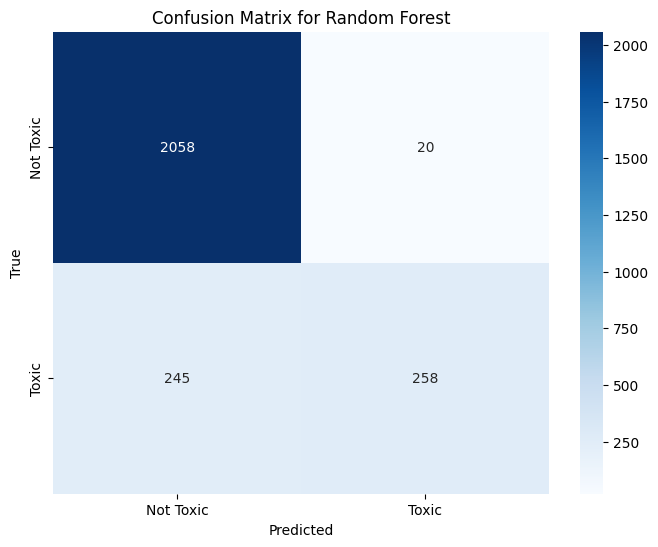

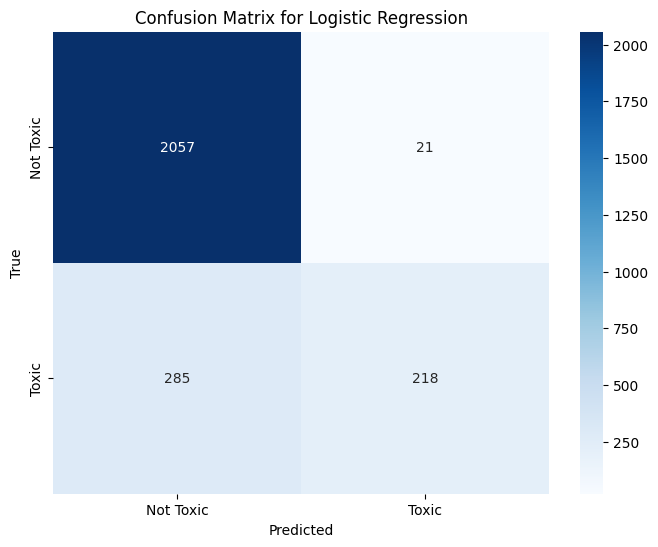

In [65]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(rf_cm, 'Random Forest')
plot_confusion_matrix(lr_cm, 'Logistic Regression')

In [70]:
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))
print("=" * 60)
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      2078
           1       0.93      0.51      0.66       503

    accuracy                           0.90      2581
   macro avg       0.91      0.75      0.80      2581
weighted avg       0.90      0.90      0.89      2581

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      2078
           1       0.91      0.43      0.59       503

    accuracy                           0.88      2581
   macro avg       0.90      0.71      0.76      2581
weighted avg       0.88      0.88      0.86      2581



Random Forest показывает более высокие значения точности и полноты, значит он лучше в этой задаче.

Ложноотрицательные результаты обоих моделей высоки, что может означать, что модели иногда пропускают токсичные сообщения. 

#### 5. Находим оптимальные гиперпараметры 

Для этогжо воспользуемся GridSearchCV

##### Сначала для Random Forest

In [72]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=random_state), rf_param_grid, cv=kf, scoring=f1_scorer)
rf_grid.fit(X_train, y_train)

print(f'Best parameters for Random Forest: {rf_grid.best_params_}')
print(f'Best score for Random Forest: {rf_grid.best_score_}')

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best score for Random Forest: 0.8869231127503532


##### Теперь для Logistic Regression

In [ ]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=random_state), lr_param_grid, cv=kf, scoring=f1_scorer)
lr_grid.fit(X_train, y_train)

print(f'Best parameters for Logistic Regression: {lr_grid.best_params_}')
print(f'Best score for Logistic Regression: {lr_grid.best_score_}')

#### Итог

Теперь зная лучшие гаперпарамметры и модель попробуемя посчитать финальную метрику F1

In [22]:
model = RandomForestClassifier(random_state=random_state, n_estimators=200, max_depth=None)

model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2078
           1       0.93      0.51      0.66       503

    accuracy                           0.90      2581
   macro avg       0.91      0.75      0.80      2581
weighted avg       0.90      0.90      0.89      2581



Модель хорошо справляется с определением не токсичных сообщений, она имеет проблемы с выявлением токсичных сообщений, что достаточно важно для данного задания.

### Использование предобученных моделей (библиотека transformers)

#### 0. Подготовим dataset

In [5]:
df = pd.read_csv(preprocessed_data_path, encoding='utf-8')
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

#### 1. Токениризация

In [6]:
class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')

train_encodings = tokenizer(train_df['message'].tolist(), truncation=True, padding=True)
eval_encodings = tokenizer(eval_df['message'].tolist(), truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_df['is_toxic'].tolist())
eval_dataset = ToxicDataset(eval_encodings, eval_df['is_toxic'].tolist())

#### 2.  Инициализация модели

In [9]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [10]:
model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=2)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train()

In [11]:
eval_results = trainer.evaluate()
print(eval_results)

## Отчет

Как видно предобученная модель показала значительно более хорошие результаты.
Модели из классического ML, не очень хорошо работают с текстом6 так же там был применен самы стандартный токенеризатор, который не учитывает количесвто слов. В реальности использовать такие модели как random forest, не очень подходящий вариант, не смотря на достаточно высокие метрики, они плохо определяют именно токсичные комментарии (1), хотя это основная задача классификатора. Трансформеры с этой задачой справляются гораздо лучще, но их очень долго обучать. В целом оценку можно увеличить сделав более сбалансированный dataSet, так как в данном, после очистки осталось всего лишь 2522 токсичных комминтария, что достаточно мала, если учесть что 20% еще идут на тест.

Метрики каждой из моделей и пояснения к ним были представленны выше к markdown блоках, поэтому здесь их дублировать будет излишни.

In [15]:
df['is_toxic'].value_counts()

is_toxic
0    10380
1     2522
Name: count, dtype: int64

## Проблемы

Из проблем с которыми сталкнулся, стоит отметить, что обучения трансформера, очень ресурсозатратный процесс, с которым не справился ни Colab - он падал с привышением лимита ОЗУ, ни мой ноутбук - обусался гдето час, потом выключился. Пришлось просить друзей которые работают в области DS, что бы обучили у себя в облаках. 